WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



Fitting model with 2 components...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


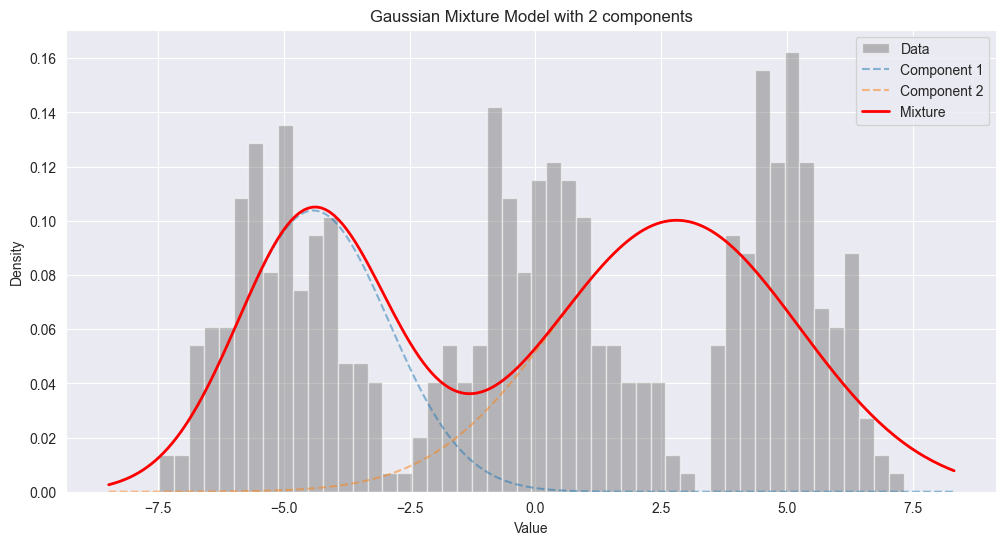


Fitting model with 3 components...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


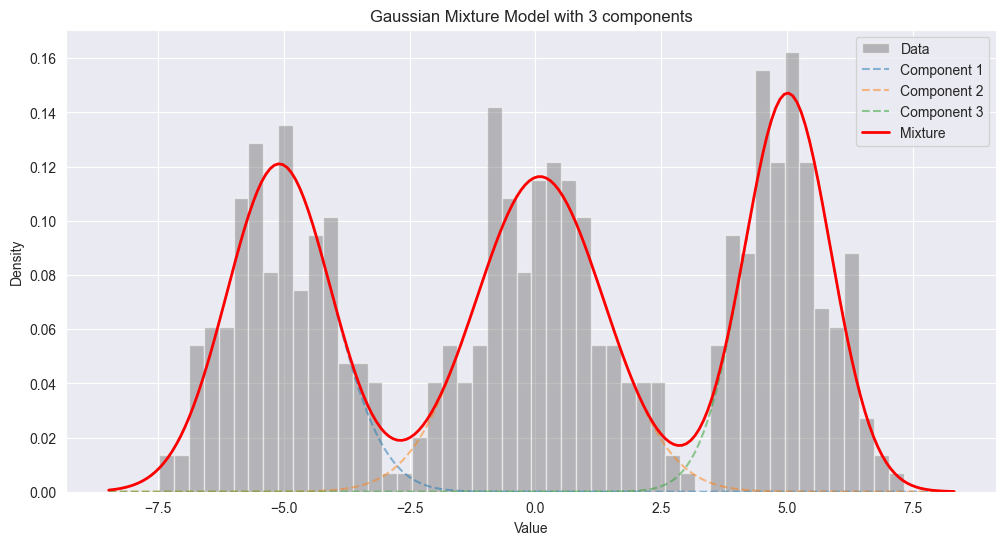


Fitting model with 4 components...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
There were 1579 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


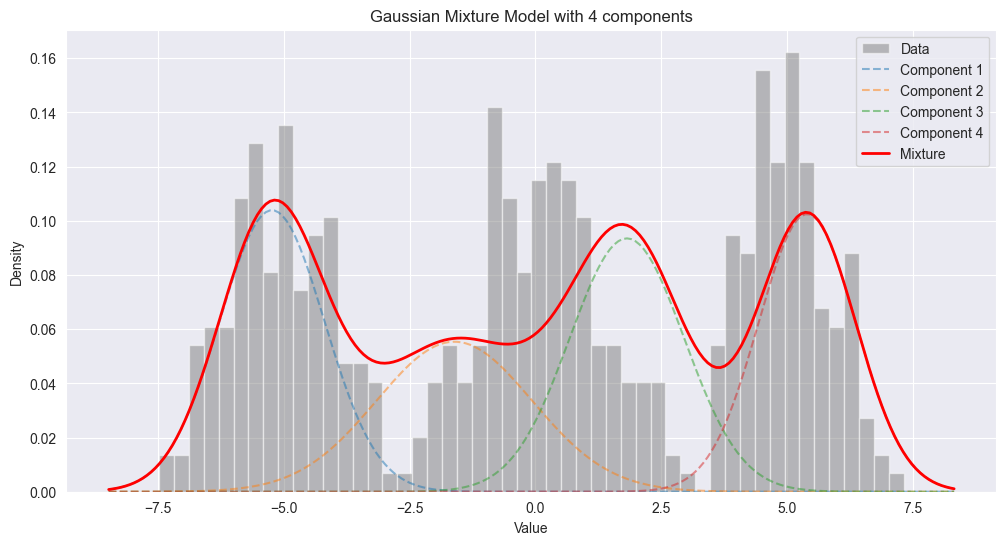


Model comparison using WAIC:


C:\Users\mihai\anaconda3\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


         rank    elpd_waic     p_waic   elpd_diff        weight         se  \
model_3     0  2530.973305   7.600377    0.000000  1.000000e+00  24.495300   
model_4     1  2531.598776   8.384373    0.625471  0.000000e+00  24.305677   
model_2     2  2729.159453  40.794551  198.186147  1.110223e-15  13.788360   

               dse  warning     scale  
model_3   0.000000    False  deviance  
model_4   0.630860    False  deviance  
model_2  17.170801     True  deviance  

Model comparison using LOO:
         rank     elpd_loo      p_loo   elpd_diff        weight         se  \
model_3     0  2530.992908   7.610179    0.000000  1.000000e+00  24.495805   
model_4     1  2531.654212   8.412091    0.661304  2.775558e-16  24.310048   
model_2     2  2728.627685  40.528667  197.634777  2.220446e-16  13.786161   

               dse  warning     scale  
model_3   0.000000    False  deviance  
model_4   0.629492    False  deviance  
model_2  17.174080    False  deviance  


<Figure size 1000x600 with 0 Axes>

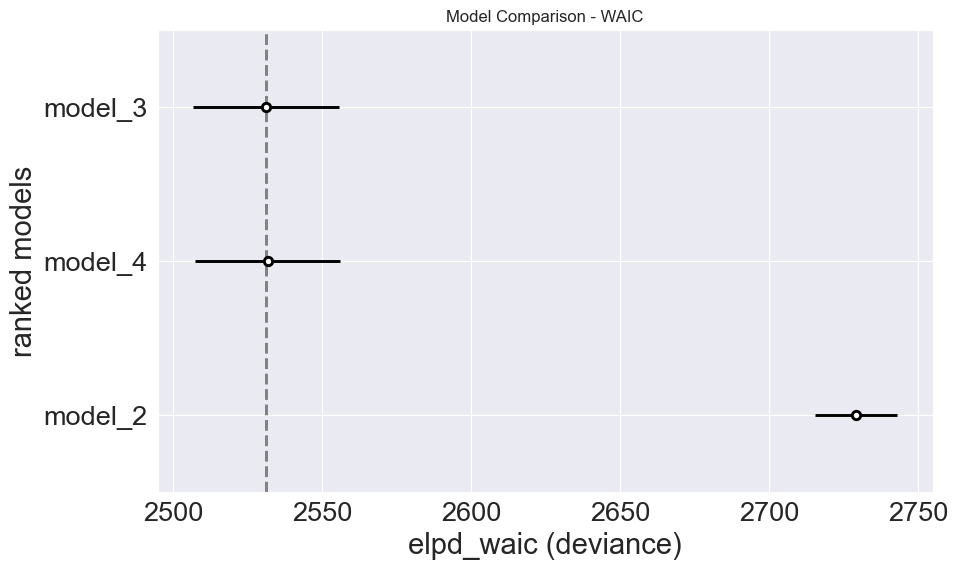

<Figure size 1000x600 with 0 Axes>

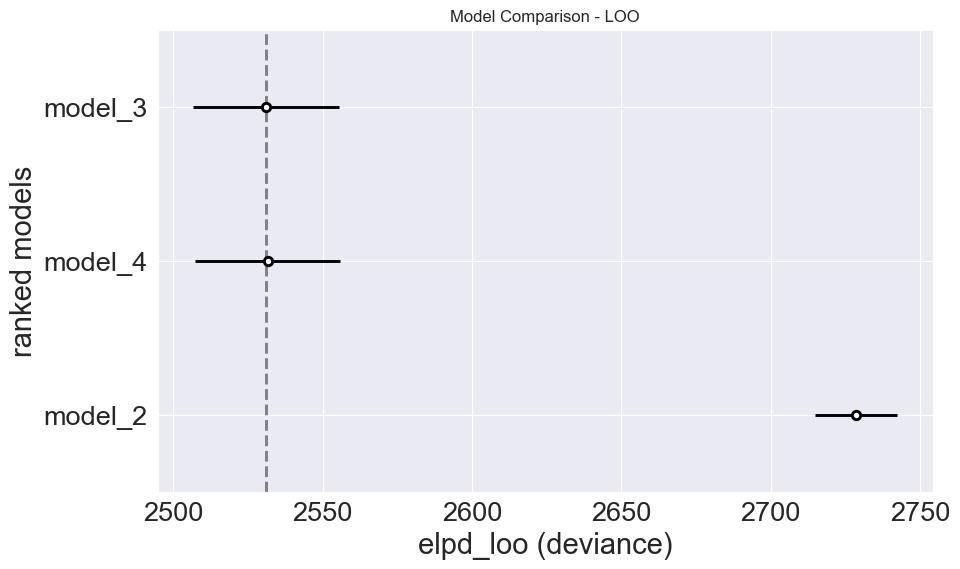

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from scipy.stats import norm

# Generate synthetic data from mixture of 3 Gaussians
np.random.seed(42)
n_samples = 500

# True parameters
true_weights = np.array([0.3, 0.4, 0.3])
true_means = np.array([-5, 0, 5])
true_stds = np.array([1, 1.5, 0.75])

# Generate data
component = np.random.choice(3, size=n_samples, p=true_weights)
data = np.random.normal(
    true_means[component],
    true_stds[component]
)

def create_mixture_model(data, n_components, random_seed=42):
    """Create and sample from a Gaussian Mixture Model."""
    
    # Calculate data statistics for informative priors
    data_min = data.min()
    data_max = data.max()
    data_range = data_max - data_min
    data_std = np.std(data)
    
    with pm.Model() as model:
        # Priors
        p = pm.Dirichlet('p', a=np.ones(n_components))
        
        # More informative priors for means
        means = pm.Normal('means', 
                         mu=np.linspace(data_min, data_max, n_components),
                         sigma=data_range/n_components)
        
        # Order means using potential with a softer constraint
        for i in range(n_components-1):
            pm.Potential(f'order_means_{i}', 
                        pm.math.switch(means[i+1] - means[i] < 0, 
                                     -1e6, 0))
        
        # Informative prior for standard deviations
        sd = pm.HalfNormal('sd', 
                          sigma=data_std,
                          shape=n_components)
        
        # Likelihood
        y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=data)
        
        # Sample with increased tune
        idata = pm.sample(1000, 
                         tune=1000,
                         random_seed=random_seed, 
                         return_inferencedata=True,
                         idata_kwargs={"log_likelihood": True})
    
    return idata, model

def plot_mixture_results(data, idata, n_components, title):
    """Plot the data and fitted mixture model."""
    plt.figure(figsize=(12, 6))
    
    # Plot histogram of data
    plt.hist(data, bins=50, density=True, alpha=0.5, color='gray', label='Data')
    
    # Get posterior samples
    p_samples = idata.posterior['p'].mean(dim=['chain', 'draw']).values
    means_samples = idata.posterior['means'].mean(dim=['chain', 'draw']).values
    sd_samples = idata.posterior['sd'].mean(dim=['chain', 'draw']).values
    
    # Plot individual components and mixture
    x = np.linspace(data.min() - 1, data.max() + 1, 200)
    mixture = np.zeros_like(x)
    
    for i in range(n_components):
        component = p_samples[i] * norm.pdf(x, means_samples[i], sd_samples[i])
        plt.plot(x, component, '--', alpha=0.5, label=f'Component {i+1}')
        mixture += component
    
    plt.plot(x, mixture, 'r-', lw=2, label='Mixture')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fit models with different numbers of components
n_components_list = [2, 3, 4]
results = {}
models = {}

for n_comp in n_components_list:
    print(f"\nFitting model with {n_comp} components...")
    idata, model = create_mixture_model(data, n_comp)
    results[f'model_{n_comp}'] = idata
    models[f'model_{n_comp}'] = model
    
    # Plot results
    plot_mixture_results(data, idata, n_comp, f'Gaussian Mixture Model with {n_comp} components')

# Compare models using WAIC
print("\nModel comparison using WAIC:")
comparison_waic = az.compare(results, ic='waic', scale='deviance')
print(comparison_waic)

# Compare models using LOO
print("\nModel comparison using LOO:")
comparison_loo = az.compare(results, ic='loo', scale='deviance')
print(comparison_loo)

# Plot model comparisons
plt.figure(figsize=(10, 6))
az.plot_compare(comparison_waic, figsize=(10, 6))
plt.title("Model Comparison - WAIC")
plt.show()

plt.figure(figsize=(10, 6))
az.plot_compare(comparison_loo, figsize=(10, 6))
plt.title("Model Comparison - LOO")
plt.show()